In [9]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm



In [53]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [122]:
CNDP_export_path = os.path.join(".", "Baseline_results")
HDA_export_path = os.path.join(CNDP_export_path, "HDA")
HPRA_export_path = os.path.join(CNDP_export_path, "HPRA")
CI_export_path = os.path.join(CNDP_export_path, "CI")
FINDER_torch_export_path = os.path.join(CNDP_export_path, "FINDER_torch")

#CI_export_path = os.path.join(CNDP_export_path, "CI")

#make_dir(CNDP_export_path)
make_dir(HDA_export_path)
make_dir(HPRA_export_path)
make_dir(CI_export_path)
make_dir(FINDER_torch_export_path)

-1

In [ ]:
# turns node labels into integers from 1 to |V|
# turn this into graph-tool?
def modify_edgelist(data_dir, save_dir, data_name=['day20']):
    for i in range(len(data_name)):
        data = os.path.join(data_dir , data_name[i] + '.edgelist')
        g = nx.read_edgelist(data)

        nodes = g.nodes()
        nodes_l = list(nodes)
        nodes_l_map = map(int, nodes_l)
        nodes_l_int = list(nodes_l_map)
        nodes_l_int.sort()

        nodes_l_map = map(str, nodes_l_int)
        nodes_l = list(nodes_l_map)

        new_node_labels = {}
        for j in range(len(nodes_l)):
            new_node_labels[nodes_l[j]] = str(j)

        new_g = nx.relabel_nodes(g, new_node_labels)

        nx.write_edgelist(new_g, os.path.join(save_dir, "{}_modified.edgelist".format(data_name[i])))

In [ ]:
#modify_edgelist(data_dir, save_dir, data_name=['day20'])

In [100]:
network_file_name = "HI-II-14_degree"
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

Number of nodes in the graph: 4165
Number of edges in the graph: 13087


In [98]:
network_comma_export_path = "./data/real/{}_comma.txt".format(network_file_name)
nx.write_edgelist(G, network_comma_export_path, delimiter=",")

In [162]:
#sum of Zs for connected components / maximum connectivity ((|V|*|V| - 1)/2) where Z=(|CC|* |CC|-1) / 2
def calc_parwise_conn(G):
    _g_num_nodes = G.number_of_nodes()
    if(_g_num_nodes in [0, 1]): return 0
    pairwise_connectivity = 0
    for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
    pc = pairwise_connectivity / (((_g_num_nodes * (_g_num_nodes - 1))) /2)
    maxCC = len(max(nx.connected_components(G), key=len))
    #print(maxCC)
    return maxCC
    #return pc

In [154]:
# high degree adaptive
def HDA(G, k=5e3, write=True):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_parwise_conn(G))

    print("HDA for k: {}".format(k))

    while(True):
        print("- ", end="")
        degrees = dict(G.degree)
        degrees_sorted = list(sorted(degrees.items(), key=lambda item: item[1], reverse=True))

        isTerminal = k > len(degrees_sorted)

        num_removals = int(min(k, len(degrees_sorted)))
        node_degree_pairs = degrees_sorted[0:num_removals]
        node_removals = [i[0] for i in node_degree_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_parwise_conn(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return pairwise_conn_list

In [155]:
# high pageRank adaptive
def HPRA(G, k=5e3, alpha=0.85, write=True):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_parwise_conn(G))

    print("HPRA for k: {}, alpha: {}".format(k, alpha))

    while(True):
        print("- ", end="")
        prs = nx.pagerank(G, alpha=alpha)
        prs_sorted = list(sorted(prs.items(), key=lambda item: item[1], reverse=True))

        isTerminal = k > len(prs_sorted)

        num_removals = int(min(k, len(prs_sorted)))
        node_pr_pairs = prs_sorted[0:num_removals]
        node_removals = [i[0] for i in node_pr_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_parwise_conn(G))

        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(HPRA_export_path, "scores_k_{}_alpha_{}.txt".format(k, alpha))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [156]:
'''
def calc_CI_score(G, node_files, k=5e3, write=True):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_parwise_conn(G))

    f = open(node_files,'r')
    node_removals = []
    for idx, line in enumerate(f.readlines()):
        nodes_line = line.split(",")[1:]
        node_removals = node_removals + nodes_line

    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]

        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_parwise_conn(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(CI_export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list
'''

'\ndef calc_CI_score(G, node_files, k=5e3, write=True):\n    k = int(k)\n    pairwise_conn_list = []\n    pairwise_conn_list.append(calc_parwise_conn(G))\n\n    f = open(node_files,\'r\')\n    node_removals = []\n    for idx, line in enumerate(f.readlines()):\n        nodes_line = line.split(",")[1:]\n        node_removals = node_removals + nodes_line\n\n    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]\n    while(True):\n        print("- ", end="")\n\n        isTerminal = k > len(node_removals)\n\n        num_removals = int(min(k, len(node_removals)))\n        curr_node_removals = node_removals[0:num_removals]\n\n        G.remove_nodes_from(curr_node_removals)\n\n        pairwise_conn_list.append(calc_parwise_conn(G))\n\n        node_removals = node_removals[num_removals:]\n        if(isTerminal): break\n\n    print("\t-Finished calculations")\n    if(write):\n        result_file = os.path.join(CI_export_path, "scores_k_{}.txt".format(k))\n        with ope

In [157]:
def calc_score_from_nodes_file(G, node_files, export_path, k=5e3, write=True, start_idx=1):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_parwise_conn(G))

    f = open(node_files,'r')
    node_removals = []
    for idx, line in enumerate(f.readlines()):
        nodes_line = line.split(",")[start_idx:]
        node_removals = node_removals + nodes_line

    
    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]
    print(len(node_removals))
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]

        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_parwise_conn(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [163]:
step_ratios = [0.01]


for s_r in step_ratios: 
    G = nx.read_gml(network_file_path, destringizer=int)
    _g_num_nodes = G.number_of_nodes()
    k = int(s_r*_g_num_nodes)
    print("Successfully imported graph with nodes:", _g_num_nodes)
    HDA_scores = HDA(G, k=k)

Successfully imported graph with nodes: 4165
HDA for k: 41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [164]:
step_ratios = [0.01]
Alphas = [0.8, 0.85, 0.9]

for s_r in step_ratios: 
    for alpha in Alphas:
        G = nx.read_gml(network_file_path, destringizer=int)
        _g_num_nodes = G.number_of_nodes()
        k = int(s_r*_g_num_nodes)
        print("Successfully imported graph with nodes:", _g_num_nodes)
        HPRA_scores = HPRA(G, k=k, alpha=alpha)

Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.8
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.85
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.9
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [165]:
# for Collective Influence (CI)
s_r = 0.01

# you need to run CI first
CI_file_path = os.path.join(".", "data", "real", "HI-II-14_degree_comma.txt_out")

G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print(_g_num_nodes)
k = int(s_r*_g_num_nodes)

CI_scores = calc_score_from_nodes_file(G, CI_file_path, CI_export_path, k=k, write=True)


4165
452
- - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [166]:
# for FINDER ND Cost Torch
s_r = 0.01

# you need to run CI first
FINDER_torch_file_path = os.path.join(".", "code", "results", "FINDER_ND_cost", 'real', 'Data_degree',\
                            'StepRatio_0.0100', 'HI-II-14_degree.txt')

G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print(_g_num_nodes)
k = int(s_r*_g_num_nodes)

FINDER_torch_scores = calc_score_from_nodes_file(G, FINDER_torch_file_path, FINDER_torch_export_path, k=k, write=True, start_idx=0)


4165
3020
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [167]:
exp_dict = {}


In [168]:
step_ratios = [0.01]
Alphas = [0.8, 0.85, 0.9]

for s_r in step_ratios:
    k = int(s_r*_g_num_nodes)
    for alpha in Alphas:
        dst_path = os.path.join(HPRA_export_path, "scores_k_{}_alpha_{}.txt".format(k, alpha))
        f = open(dst_path,'r')
        scores = []
        for idx, value in enumerate(f.readlines()):
            value = float(value)
            scores.append(value)

        #scores = scores[::int(5000/k)]

        exp_dict["HPRA α: {}, k: {}".format(alpha, k)] = scores

In [169]:
for s_r in step_ratios:
    k = int(s_r*_g_num_nodes)
    dst_path = os.path.join(HDA_export_path, "scores_k_{}.txt".format(k))
    f = open(dst_path,'r')
    scores = []
    for idx, value in enumerate(f.readlines()):
        value = float(value)
        scores.append(value)

    #scores = scores[::int(5000/k)]

    exp_dict["HDA k: {}".format(k)] = scores

Text(0, 0.5, 'Pairwise connectivity')

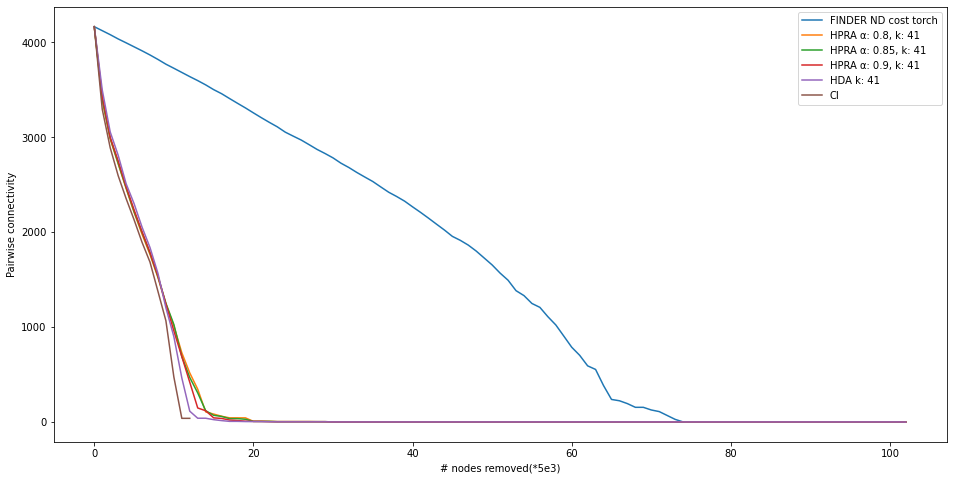

In [170]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(FINDER_torch_scores, label='FINDER ND cost torch')
#plt.plot(CN_scores, label='CN')
for key in exp_dict.keys():
    plt.plot(exp_dict[key], label=key)
    
plt.plot(CI_scores, label='CI')
plt.legend()
plt.xlabel("# nodes removed(*5e3)")
plt.ylabel("Pairwise connectivity")

In [171]:
len(FINDER_torch_scores)

75